In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

In [97]:
file = open("../../data/features/2019_05_07_all_features.pickle",'rb')
df = pickle.load(file, encoding='utf-8')
df.columns

Index(['id', 'Datetime', 'text', 'sentiment', 'subjectivity', 'retweets',
       'favorites', 'isreply', 'year', 'month', 'day', 'date', 'DayofWeek',
       'Weekend', 'Time', 'BinaryTrading', 'DayDistance', 'Hour',
       'Time_Difference', 'gtrend', 'countComment', 'posCommentAmount',
       'negCommentAmount', 'neuCommentAmount', 'posCommentSum',
       'negCommentSum', 'CommentSD', 'posCommentSD', 'negCommentSD'],
      dtype='object')

In [98]:
df.shape

(854, 29)

In [99]:
print(df.isnull().sum())

id                  0
Datetime            0
text                0
sentiment           0
subjectivity        0
retweets            0
favorites           0
isreply             0
year                0
month               0
day                 0
date                0
DayofWeek           0
Weekend             0
Time                0
BinaryTrading       0
DayDistance         0
Hour                0
Time_Difference     0
gtrend              0
countComment        0
posCommentAmount    0
negCommentAmount    0
neuCommentAmount    0
posCommentSum       0
negCommentSum       0
CommentSD           0
posCommentSD        0
negCommentSD        0
dtype: int64


In [95]:
# drop one observation with NaN 'employer_yr_established'
df = df[np.isfinite(df['That_hour_residual'])]

KeyError: 'That_hour_residual'

In [101]:
df[['posCommentAmount', 'negCommentAmount', 'neuCommentAmount',
       'posCommentSum', 'negCommentSum', 'CommentSD', 'posCommentSD',
       'negCommentSD']].head()

,posCommentAmount,negCommentAmount,neuCommentAmount,posCommentSum,negCommentSum,CommentSD,posCommentSD,negCommentSD
0,153,74,500,50.753,-20.458,0.212,0.228,0.217
1,63,30,59,18.228,-4.240,0.237,0.234,0.132
2,137,89,193,35.958,-18.383,0.228,0.210,0.194
3,34,22,47,9.682,-3.011,0.212,0.217,0.120
4,62,28,81,20.154,-5.281,0.253,0.241,0.196


In [65]:
df['Time_Difference'].describe()

count     854.000000
mean     2017.537471
std         1.020482
min      2015.000000
25%      2017.000000
50%      2018.000000
75%      2018.000000
max      2019.000000
Name: Time_Difference, dtype: float64

In [ ]:
Index(['id', 'Datetime', 'text', 'sentiment', 'subjectivity', 'retweets',
       'favorites', 'isreply', 'year', 'month', 'day', 'date', 'DayofWeek',
       'Weekend', 'Time', 'BinaryTrading', 'DayDistance', 'Hour',
       'Time_Difference', 'gtrend', 'countComment', 'posCommentAmount',
       'negCommentAmount', 'neuCommentAmount', 'posCommentSum',
       'negCommentSum', 'CommentSD', 'posCommentSD', 'negCommentSD'],
      dtype='object')

In [66]:
# prepare X and Y

X = df[['sentiment', 'subjectivity',
        'DayofWeek', 'Weekend', 'TradingHour', 'DayDistance', 
        'gtrend', 
        'countComment', 'CommentSD', 'neuCommentAmount',
        'posCommentAmount', 'posCommentSum', 'posCommentSD',
        'negCommentAmount', 'negCommentSum',  'negCommentSD']]

Y = df['That_hour_volume_perc']
#Y = df[['That_hour_volume', 'That_hour_volume_perc', 'That_hour_residual']]

KeyError: "['TradingHour'] not in index"

In [67]:
num_features = len(X.columns)

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=100)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(476, 16) (476,)
(53, 16) (53,)


### 1. Linear Regression

In [81]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

print("Linear Reg R^2 training is: {}".format(linear_reg.score(X_train, Y_train)))

print("Linear Reg Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, linear_reg.predict(X_train)))))
print("Linear Reg Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, linear_reg.predict(X_test)))))

Linear Reg R^2 training is: 0.31492609593309706
Linear Reg Train RMSE is: 0.0997545518677333
Linear Reg Test RMSE is: 0.09194339345354793


### 2a. Simple Random Forest

In [70]:
# Random Forest
random_forest = RandomForestRegressor(n_estimators=100)     # instantiate
random_forest.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(random_forest.score(X_train, Y_train)))                

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, random_forest.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, random_forest.predict(X_test)))))

Random Forest R^2 training is: 0.8974841507278681
Random Forest Train RMSE is: 0.0385886438931958
Random Forest Test RMSE is: 0.09486376914421067


### 2b. Random Forest with Cross Validation

In [84]:
rf_cv = RandomForestRegressor(n_estimators=1000, max_depth=70, max_features=np.sqrt(num_features), random_state=10)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = [5,10]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]

# create the hyperparameter grid
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth}

print(hyperparam_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': [10], 'max_depth': [10, 20, 30, 40, 50]}


In [ ]:

rf_random = RandomizedSearchCV(estimator = rf_cv, 
                               param_distributions, 
                               n_iter=10, 
                               scoring=None, 
                               n_jobs=None, 
                               iid=’warn’, 
                               refit=True, 
                               cv=’warn’, 
                               verbose=0, 
                               pre_dispatch=‘2*n_jobs’, 
                               random_state=None, 
                               error_score=’raise-deprecating’, 
                               return_train_score=False)[source]


In [85]:
rf_grid = GridSearchCV(estimator = rf_cv, 
                       param_grid = hyperparam_grid,
                       cv = 5,
                       verbose=2,
                       n_jobs = -1)

# fit the grid search model
rf_grid.fit(X_train, Y_train)

# best hyperparameters
rf_grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] max_depth=10, max_features=10, n_estimators=200 .................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................
[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................
[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................
[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=400 .................
[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................
[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................
[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................
[CV] .

[CV] .. max_depth=30, max_features=10, n_estimators=400, total=   0.8s
[CV] max_depth=30, max_features=10, n_estimators=600 .................
[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=30, max_features=10, n_estimators=600 .................
[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=30, max_features=10, n_estimators=600 .................
[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=30, max_features=10, n_estimators=600 .................
[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=30, max_features=10, n_estimators=600 .................
[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=30, max_features=10, n_estimators=800 .................
[CV] .. max_depth=30, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=30, max_features=10, n_estimators=800 .................
[CV] .

[CV] .. max_depth=50, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=50, max_features=10, n_estimators=800 .................
[CV] .. max_depth=50, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=50, max_features=10, n_estimators=800 .................
[CV] .. max_depth=50, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................
[CV] . max_depth=50, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................
[CV] . max_depth=50, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................
[CV] . max_depth=50, max_features=10, n_estimators=1000, total=   2.0s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................
[CV] . max_depth=50, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................
[CV] .

[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.5min finished
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 10, 'max_features': 10, 'n_estimators': 800}

In [86]:
# use optimal hyperparameters
rf_cv = RandomForestRegressor(n_estimators=800, max_depth=10, max_features=10, random_state=10)
rf_cv.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(rf_cv.score(X_train, Y_train)))                

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, rf_cv.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, rf_cv.predict(X_test)))))

Random Forest R^2 training is: 0.8601573571684711
Random Forest Train RMSE is: 0.04506961218953326
Random Forest Test RMSE is: 0.09234177978977418


### 3. Xtreme Gradient Boosting

Parameter Reference: https://www.datacamp.com/community/tutorials/xgboost-in-python

Default Hyperparams:  
 - XGB Train RMSE is: 0.0627184664815691  
 - XGB Test RMSE is: 0.10047705976306533

In [73]:
xgb = XGBRegressor(objective ='reg:linear', 
                   colsample_bytree = 0.3, 
                   learning_rate = 0.1,
                   max_depth = 5, 
                   alpha = 10, 
                   n_estimators = 40)

xgb.fit(X_train, Y_train)

print("XGB R^2 training is: {}".format(xgb.score(X_train, Y_train)))                

print("XGB Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, xgb.predict(X_train)))))
print("XGB Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, xgb.predict(X_test)))))

XGB R^2 training is: 0.7848313696962358
XGB Train RMSE is: 0.055905365001703025
XGB Test RMSE is: 0.09439305722879879


/jet/var/python/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [89]:
modellist = [linear_reg, rf_cv,xgb]
modelname = ['log','rf','xgb']  

boot = [20,50,100]
from sklearn.metrics import mean_absolute_error

bootstrap = pd.DataFrame(columns=['size','model','mean','sd','CI','LB','UB'])
err = pd.DataFrame(columns=['size','model','mse'])
for n in boot:
    errors   = np.zeros((n, len(modellist)))
    
    for b in range(0,n):
        for i,model in enumerate(modellist):
            index = np.random.choice(list(range(0,len(X_test))),len(X_test), replace=True)
            errors[b,i] = np.sqrt(mean_squared_error(Y_test.iloc[index], model.predict(X_test.iloc[index])))
            err = err.append(pd.DataFrame([{'size': n, 'model' : modelname[i],'MSE' : errors[b,i]  }])) 
            
    bootstrapres = pd.DataFrame({'size': n, 'model' : modelname,'mean' : errors.mean(axis=0) ,'sd' : np.std(errors, axis=0)})
#     print(bootstrapres)
    bootstrapres['CI'] = [ 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['LB'] = [b[2] - 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['UB'] = [b[2] + 1.96* b[3] for _,b in bootstrapres.iterrows()]
    
    bootstrap = bootstrap.append(bootstrapres) 



/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, 

  size model  mean    sd    CI    LB    UB
0   20   log 0.092 0.015 0.030 0.062 0.122
1   20    rf 0.095 0.011 0.021 0.074 0.116
2   20   xgb 0.093 0.012 0.024 0.070 0.117
0   50   log 0.088 0.012 0.024 0.064 0.113
1   50    rf 0.092 0.009 0.018 0.074 0.111
2   50   xgb 0.095 0.012 0.024 0.071 0.119
0  100   log 0.092 0.014 0.027 0.065 0.118
1  100    rf 0.092 0.009 0.018 0.074 0.111
2  100   xgb 0.095 0.009 0.018 0.078 0.113


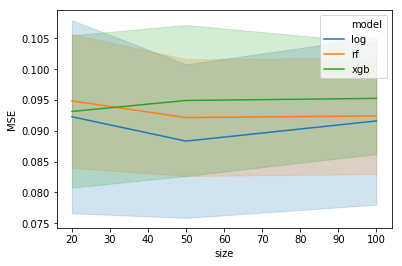

In [90]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(bootstrap)
import seaborn as sns
ax = sns.lineplot(x="size", y="MSE",
             hue="model",ci='sd', 
             data=err)
# ax.fill_between(bootstrap.size, bootstrap.LB, bootstrap.UB, color='#888888', alpha=0.2)

plt.show()